In [40]:
import biom
import skbio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bp import parse_newick, to_skbio_treenode
from gneiss.util import NUMERATOR, DENOMINATOR
from sklearn.metrics import roc_auc_score
%matplotlib inline

Joint microbe / metabolite analysis

In [107]:
mmV = pd.read_excel('../results/microb_metabolites_analysis_ilr.xlsx', 
                    sheet_name='Figure VD', index_col=0)
tree = to_skbio_treenode(parse_newick(open('../data/combined/tree.nwk').read()))

taxonomy = pd.read_table(
    '/Users/mortonjt/Documents/research/databases/gg/'
    'gg_13_5_otus/taxonomy/97_otu_taxonomy.txt',
    header=None, dtype=str
).set_index(0)


metabolite_fmd = pd.read_table('../data/hcc-data/metabolite_feature_metadata.txt',
                               index_col=0)

micro_tree = tree.children[0]
metab_tree = tree.children[1]
micro_nodes = [n.name for n in micro_tree.levelorder(include_self=True) if not n.is_tip()]
metab_nodes = [n.name for n in metab_tree.levelorder(include_self=True) if not n.is_tip()]

micro_nodes = set(micro_nodes) & set(mmV.index)
metab_nodes = set(metab_nodes) & set(mmV.index)

microbeV2 = mmV.loc[micro_nodes]
metaboliteV2 = mmV.loc[metab_nodes]

/var/folders/w2/6wc3tcs56jl0x12ct8r03pf5h8vjhg/T/ipykernel_77742/99574601.py:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  microbeV2 = mmV.loc[micro_nodes]
/var/folders/w2/6wc3tcs56jl0x12ct8r03pf5h8vjhg/T/ipykernel_77742/99574601.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  metaboliteV2 = mmV.loc[metab_nodes]


Microbial sample metadata

In [8]:
instruments = pd.read_table('../data/instrument.txt', index_col=0)
phenotype = pd.read_table('../data/phenotype.txt', index_col=0)

confounder = pd.read_csv('../data/cleaned-data/microbiome_confounder.csv', index_col=0)
family = pd.read_csv('../data/cleaned-data/microbiome_family.csv', index_col=0)
instrument = pd.read_csv('../data/cleaned-data/microbiome_instrume.csv', index_col=0)
outcome = pd.read_csv('../data/cleaned-data/microbiome_outcome.csv', index_col=0)

outcome.index = family.index # fingers crossed!
instrument.index = family.index 
confounder.index = family.index 

microbe_md = pd.merge(outcome, confounder, left_index=True, right_index=True)
microbe_md = pd.merge(microbe_md, instruments, left_index=True, right_index=True)

otu_table = biom.load_table('../data/hcc-data/46119_otu_table.biom').to_dataframe().T
taxonomy = taxonomy.loc[otu_table.columns]
#otu_table.columns = list(map(lambda x: f'X{x}', otu_table.columns))
#family = otu_table.loc[microbe_md.index]

Metabolomics sample metadata

In [9]:
metabolites = biom.load_table('../data/hcc-data/metabolites.biom').to_dataframe().T
metabolite_md = pd.read_table('../data/hcc-data/metabolite_feature_metadata.txt', index_col=0)
metabolites = metabolites[metabolite_md.index]

metadata = pd.read_table('../data/hcc-data/cleaned_qiime_metadata.txt', index_col=0)
host_md = pd.read_table('../data/sample_information_from_prep_2458.tsv', index_col=0)
metadata = pd.merge(metadata, host_md[['host_subject_id']].reset_index(), 
                    left_index=True, right_on='host_subject_id')

del microbe_md['obese']
del microbe_md['HCC']

metadata = pd.merge(metadata, microbe_md.reset_index(), left_on='sample_id', right_on='index')
metadata = metadata.set_index('host_subject_id')
metadata, metabolites = metadata.align(metabolites, join='inner', axis=0)
#metabolites = metabolites.loc[:, metabolite_fmd['sampleid'].values]

# re-align microbial data
otu_table = otu_table.loc[metadata['sample_id'].values]
otu_table.index = metadata.index

Summaries

In [10]:
microbeV2.sort_values('V1').head()

,V1,V2
clade11,-3.076267,0.411247
clade78,-1.869112,0.000000
clade56,-1.640055,0.113239
clade822,-1.158112,-0.738956
clade174,-0.980877,0.000000


,V1,V2
y1386,-4.517932,-2.009006
y863,-4.434091,-0.941935
y4719,-4.223902,-0.817165
y3205,-4.117993,-0.469456
y1439,-3.953880,0.104277
y877,-3.941337,0.000000
y2113,-3.937212,-1.595995
y6946,-3.798876,0.000000
y6027,-3.779600,0.683764
y2376,-3.768744,-0.349802


In [27]:
def get_tips(tree, clade_name):
    
    num = [n.name for n in micro_tree.find(clade_name).children[NUMERATOR].tips()]
    denom = [n.name for n in micro_tree.find(clade_name).children[DENOMINATOR].tips()]
    
    if tree.find(clade_name).children[NUMERATOR].is_tip():
        num = tree.find(clade_name).children[NUMERATOR].name
    if tree.find(clade_name).children[DENOMINATOR].is_tip():
        denom = tree.find(clade_name).children[DENOMINATOR].name
    
    return num, denom

In [45]:
# metabolite balance
metabolite_res = {}
bname = 'V1'
for node_name in metaboliteV2.sort_values('V1').index:
    try:
        num, denom = get_tips(metab_tree, node_name)
        v = np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)
    except:
        # skip over tippy balances with a single feature in the numerator / denominator
        continue
    metadata[f'metabolite{bname}'] = v
    t, p = ttest_ind(metadata['metaboliteV1'].loc[metadata['HCC']],
                     metadata['metaboliteV1'].loc[~metadata['HCC']])
    a = roc_auc_score(metadata['HCC'].astype(np.int64), metadata['metaboliteV1'])
    metabolite_res[node_name] = pd.Series({'tstat': t, 'pval': p, 'auc': a})
metabolite_res = pd.DataFrame(metabolite_res).T

In [48]:
metabolite_res.sort_values('auc')

,tstat,pval,auc
y6230,-11.559409,6.520261e-27,0.215456
y2372,-10.488314,6.184045e-23,0.237243
y5914,-9.275259,1.065634e-18,0.244288
y6985,-9.033287,6.827392e-18,0.255748
y1285,-8.625576,1.452338e-16,0.267402
...,...,...,...
y4853,8.395095,7.845679e-16,0.747171
y881,10.059116,2.114105e-21,0.747798
y2120,9.835060,1.291337e-20,0.753806
y5236,10.179397,7.924410e-22,0.758945


In [49]:
# microbe balance
microbe_res = {}
bname = 'V1'
for node_name in microbeV2.sort_values('V1').index:
    try:
        num, denom = get_tips(metab_tree, node_name)
        v = np.log(otu_table[num] + 1).mean(axis=1) - np.log(otu_table[denom] + 1).mean(axis=1)
    except:
        # skip over tippy balances with a single feature in the numerator / denominator
        continue
    metadata[f'microbe{bname}'] = v
    t, p = ttest_ind(metadata['microbeV1'].loc[metadata['HCC']],
                     metadata['microbeV1'].loc[~metadata['HCC']])
    a = roc_auc_score(metadata['HCC'].astype(np.int64), metadata['microbeV1'])
    microbe_res[node_name] = pd.Series({'tstat': t, 'pval': p, 'auc': a})
microbe_res = pd.DataFrame(microbe_res).T

In [51]:
microbe_res.sort_values('auc')

,tstat,pval,auc
clade56,-7.316846,1.368951e-12,0.328468
clade78,-7.525269,3.424260e-13,0.328480
clade822,-5.283814,2.068973e-07,0.360665
clade11,-4.442418,1.148627e-05,0.395686
clade174,-3.695272,2.497609e-04,0.450153
clade3,-3.463688,5.895211e-04,0.451637
clade42,-1.643191,1.011177e-01,0.483292
clade28,0.868267,3.857609e-01,0.506406
clade29,1.341047,1.806551e-01,0.533838
clade683,1.892728,5.910505e-02,0.569016


In [93]:
# metabolite balance
bname = 'V1'
node_name = 'y6230'
#thres = 0.005
thres = 0
num, denom = get_tips(metab_tree, node_name)
metab_num, metab_denom = num, denom
v = np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)
metadata[f'metabolite{bname}'] = v

# microbe balance
#thres = 0.005
thres = 0
node_name = 'clade56'
num, denom = get_tips(micro_tree, node_name)
micro_num, micro_denom = num, denom
v = np.log(otu_table[num] + 1).mean(axis=1) - np.log(otu_table[denom] + 1).mean(axis=1)
metadata[f'microbe{bname}'] = v

Microbe / Metabolite balance

Text(0.5, 0, 'obesity')

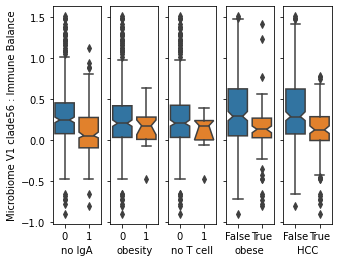

In [136]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metadata, y=f'microbe{bname}', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='obese', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='HCC', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel(f'Microbiome {bname} clade56 : Immune Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

Text(0.5, 0, 'obesity')

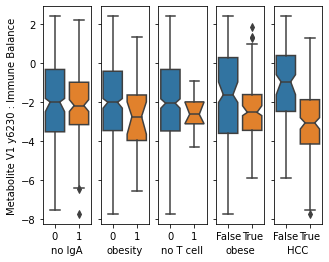

In [137]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metadata, y=f'metabolite{bname}', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='obese', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='HCC', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel(f'Metabolite {bname} y6230 : Immune Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

In [96]:
from scipy.stats import ttest_ind
ttest_ind(metadata['microbeV1'].loc[metadata['HCC']],
          metadata['microbeV1'].loc[~metadata['HCC']])

Ttest_indResult(statistic=-7.316846408427564, pvalue=1.3689514075099432e-12)

In [97]:
ttest_ind(metadata['metaboliteV1'].loc[metadata['HCC']],
          metadata['metaboliteV1'].loc[~metadata['HCC']])

Ttest_indResult(statistic=-11.559409011752065, pvalue=6.520261499827845e-27)

In [127]:
for node_name in microbe_res.index:
    if microbe_res.loc[node_name, 'pval'] > 1e-6: continue
    num, denom = get_tips(micro_tree, node_name)
    num = set(num)
    denom = set(denom)
    def clade_set(x):
        if x in set(num):
            return 'num'
        if x in set(denom):
            return 'denom'
    taxonomy[node_name] = list(map(clade_set, taxonomy.index))

In [128]:
taxonomy = taxonomy.rename(columns={1: 'Taxon'})
taxonomy.to_csv('../results/microbe_ilr_metadata.csv')
microbe_res.to_csv('../results/microbe_ilr_summary.csv')

In [ ]:
for node_name in metabolite_res.index:
    if metabolite_res.loc[node_name, 'pval'] > 1e-6: continue
    num, denom = get_tips(micro_tree, node_name)
    num = set(num)
    denom = set(denom)
    def clade_set(x):
        if x in set(num):
            return 'num'
        if x in set(denom):
            return 'denom'
    metabolite_fmd[node_name] = list(map(clade_set, metabolite_fmd.index))

In [135]:
metabolite_fmd.to_csv('../results/metabolite_ilr_metadata.csv')
metabolite_res.to_csv('../results/metabolite_ilr_summary.csv')

In [ ]:
microbe_fmd = pd.merge(microbeV2, microbe_fmd, 
                       left_index=True, right_index=True).sort_values('V1')

In [ ]:
microbeV2.sum(axis=0)

In [ ]:
metabolite_fmd = pd.merge(metaboliteV2,
                          metabolite_fmd.set_index('sampleid'), 
                          left_index=True, right_index=True)

In [ ]:
metabolite_fmd

In [ ]:
(metabolite_fmd
 .sort_values('V1')
 #.dropna(subset='Compound_Name')
 .tail(50)[['V1', 'Compound_Name']])

In [ ]:
# flip sign because of U
microbe_fmd = pd.merge(microbe_fmd, microbe_ranks, left_index=True, right_index=True)

In [ ]:
microbe_fmd.sort_values('V3')

In [ ]:
# flip sign because of U
metabolite_ranks.sort_values()

In [ ]:
metabolite_fmd[['Compound_Name', 'V3']].sort_values('V3').dropna().head(10)

In [ ]:
metabolite_fmd[['Compound_Name', 'V3']].sort_values('V3').dropna().tail(10)

In [ ]:
metabolite_fmd.to_csv('../results/metabolite_ranks.csv')

## Cross-reference against MMvec

In [ ]:
from skbio import OrdinationResults
res = OrdinationResults.read('../results/mmvec/omics-biplot.results')

In [ ]:
res.samples.shape, metabolite_fmd.shape

In [ ]:
res.samples.loc[metabolite_fmd.index]

In [ ]:
res.features